In [1]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

#### Load Data

In [3]:
AAPL_data = pd.read_csv('Data/AAPL.csv')

#### Extract train and test data

We will extract the last month's data as the test data and the rest as the train data

We take the date from 2022-02-24 to 2023-01-31 as the train data and make the test data from 2023-02-01 to 2023-02-23

In [4]:
train_df = AAPL_data[(AAPL_data['Date']>'2022-02-23') & (AAPL_data['Date']<='2023-01-31')]
test_df = AAPL_data[(AAPL_data['Date']>'2023-01-31')]

In [5]:
X_train = train_df.drop(['Date','Open'],axis=1)
y_train = np.array(train_df[['Open']]).reshape(-1)
X_test = test_df.drop(['Date','Open'],axis=1)
y_test = np.array(test_df[['Open']]).reshape(-1)

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
#List Hyperparameters that we want to tune.
parameters_KNN = {
    'n_neighbors': (1,20, 1),
    'leaf_size': (20,40,1),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev')
}
#Create new KNN object
knn = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn, parameters_KNN, scoring='accuracy', cv=5, n_jobs=-1)
#Fit the model
best_model = clf.fit(X_train, y_train.astype(int))


/Users/jiaweima/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/jiaweima/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

In [8]:
best_model.best_params_

{'leaf_size': 20,
 'metric': 'minkowski',
 'n_neighbors': 20,
 'p': 1,
 'weights': 'distance'}

#### Evaluate Model

In [9]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

#### Base Model

In [10]:
base_model = KNeighborsClassifier()
base_model.fit(X_train, y_train.astype(int))
evaluate(base_model, X_test,y_test)

Model Performance
Average Error: 2.7731 degrees.
Accuracy = 98.17%.


98.16929466217016

#### Best Model

In [11]:
model = KNeighborsClassifier(leaf_size=20, metric='minkowski', n_neighbors= 20, p= 1, weights= 'distance')
model.fit(X_train, y_train.astype(int))
evaluate(model, X_test,y_test)

Model Performance
Average Error: 1.5019 degrees.
Accuracy = 99.01%.


99.00520037344431

#### Plot Predictions

In [12]:
y_pred = model.predict(X_test)
predict_df = pd.concat([pd.DataFrame(y_pred, columns=['Predict']), pd.DataFrame(y_test, columns=['Actual'])],axis=1)
predict_df.set_index(np.array(AAPL_data[(AAPL_data['Date']>'2023-01-31')].Date),inplace=True)

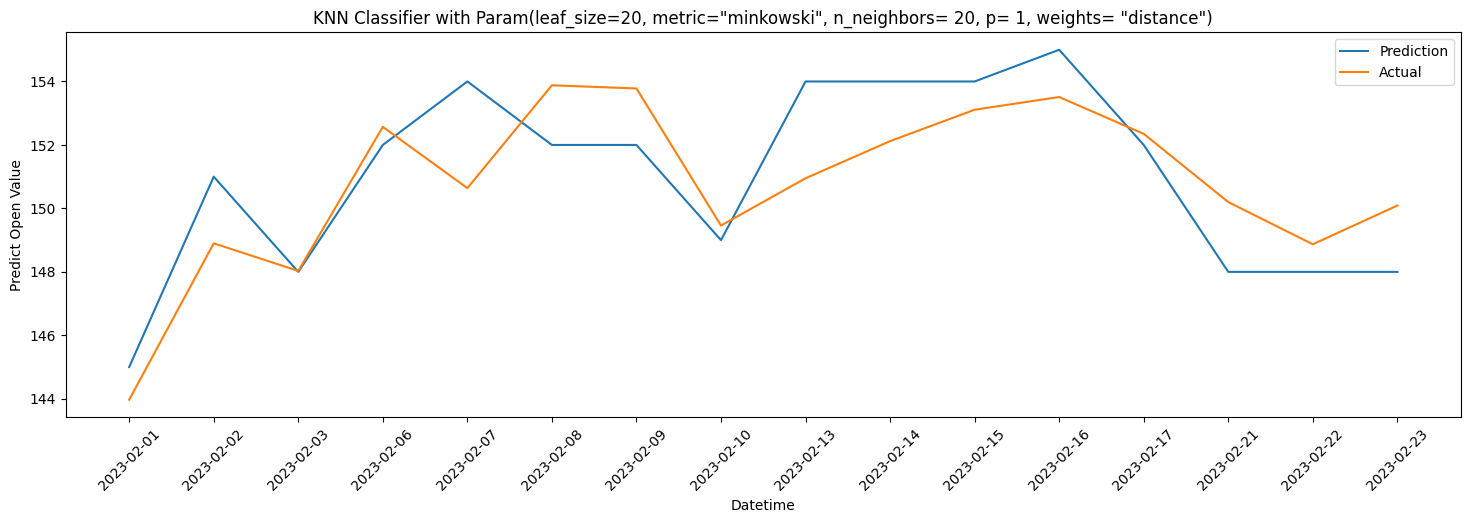

In [13]:
plt.figure(figsize=(18,5))
plt.plot(predict_df['Predict'], label='Prediction')
plt.xticks(rotation=45)
plt.plot(predict_df['Actual'], label='Actual')
plt.title('KNN Classifier with Param(leaf_size=20, metric="minkowski", n_neighbors= 20, p= 1, weights= "distance")')
plt.xlabel('Datetime')
plt.ylabel('Predict Open Value')
plt.legend()
plt.show()